# load essential and useful packages

In [1]:
import numpy as np
import os
import emcee
import scipy
import corner
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import time
os.chdir('/scratch/vp91/yq5547/notebooks') # This is my working directory

# let's load the emulator first

In [2]:
emulator = tf.keras.models.load_model('emulator')

2023-06-12 22:49:39.232864: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-12 22:49:39.232938: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-bdw-0173.gadi.nci.org.au): /proc/driver/nvidia/version does not exist


again define limits/parameters which can be intuitive

In [3]:
# define the meaning for the features, i.e. your model parameters
parameters = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])
                       
# and their limits
limits = np.array([[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]])

# define prior

In [4]:
def log_prior(theta):
    theta = (np.array(theta) - limits[:,0]) / (limits[:,1] - limits[:,0])
    if np.any(theta<0) or np.any(theta>1):    
        return -np.inf
    else:
        return 0.

# define likelihood

In [5]:
def log_likelihood(theta):
    theta = (np.array(theta) - limits[:,0]) / (limits[:,1] - limits[:,0])

    model = emulator.predict(theta.reshape([1,-1]))[0]
    total_sum = 0
    current_index = 0
    
    # neutral fraction
    McGreer_NF = model[current_index]
    current_index+=1
    if McGreer_NF>1.: 
        McGreer_NF=1 # physical prior
   
    McGreer_Mean = 0.06
    McGreer_OneSigma = 0.05
    if McGreer_NF>McGreer_Mean:
        total_sum += np.square((McGreer_Mean - McGreer_NF) / McGreer_OneSigma) # 1side Gaussian
        
    
    # CMB optical depth
    tau_value = model[current_index]
    current_index+=1
    
    # Mean and one sigma errors for the Planck constraints, 2006.16828
    PlanckTau_Mean = 0.0569
    PlanckTau_OneSigma_u = 0.0081
    PlanckTau_OneSigma_l = 0.0066
    total_sum += np.square( PlanckTau_Mean - tau_value )/(PlanckTau_OneSigma_u * PlanckTau_OneSigma_l +
                 (PlanckTau_OneSigma_u - PlanckTau_OneSigma_l) * (tau_value - PlanckTau_Mean))     # one way to write likelihood for 2-side Gaussian

    
    #z=8 21cm PS
    for redshift in [8, 10]:
        k_start = np.fromfile('HERA_Phase1_Limits/k_start_z%d.bin'%redshift, dtype=int)[0]
        ks = slice(k_start-1, None, 2)
        k_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_ks_z%d.bin'%redshift)
        kwf_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_kwfs_z%d.bin'%redshift)
        Nkbins = len(k_limit_vals)
        Nkwfbins = len(kwf_limit_vals)
        PS_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_vals_z%d.bin'%redshift)
        PS_limit_vars = np.fromfile('./HERA_Phase1_Limits/PS_limit_vars_z%d.bin'%redshift)

        ModelPS_val = 10**model[current_index:current_index+len(PS_limit_vals)]
        current_index+=len(PS_limit_vals)

        error_val = np.sqrt(PS_limit_vars + (0.2*ModelPS_val)**2 )
        likelihood = 0.5 + 0.5 * scipy.special.erf( ( PS_limit_vals - ModelPS_val ) / (np.sqrt(2) * error_val) ) # another way to write likelihood for 1-side Gaussian
        likelihood[likelihood <= 0.0] = 1e-50
        total_sum += -2 * np.sum(np.log(likelihood))
        


    # UV LF
    redshift=6
    fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
    observation = np.loadtxt(fLF)
    observation = observation[observation[:,0]>-20]
    modelled_LF = 10**model[current_index:current_index+len(observation)]
    current_index+=len(observation)   
    
    total_sum += np.sum(np.square((observation[:,1] - modelled_LF) / observation[:,2]))
    
    return -0.5 * total_sum

# now get the full log probability function

In [6]:
def log_probability(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# setup emcee and run mcmc

In [7]:
nwalkers = 32
nepochs = 2000

pos0 = np.array([-1.2, 0.5, -1.3, -0.15, 8.1, 0.6, 40.5, 1.1, 1.6 ]) +\
       1e-2 * np.random.randn(nwalkers, len(parameters))

sampler = emcee.EnsembleSampler(nwalkers, len(parameters), log_probability)

t0=time.time()
sample = sampler.run_mcmc(pos0, nepochs);
te=time.time()
print('Cost %d sec for %d epoches'%(te-t0, nepochs))

2023-06-12 23:05:18.351737: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


Cost 2269 sec for 2000 epoches


# visualize how the chain evolves 

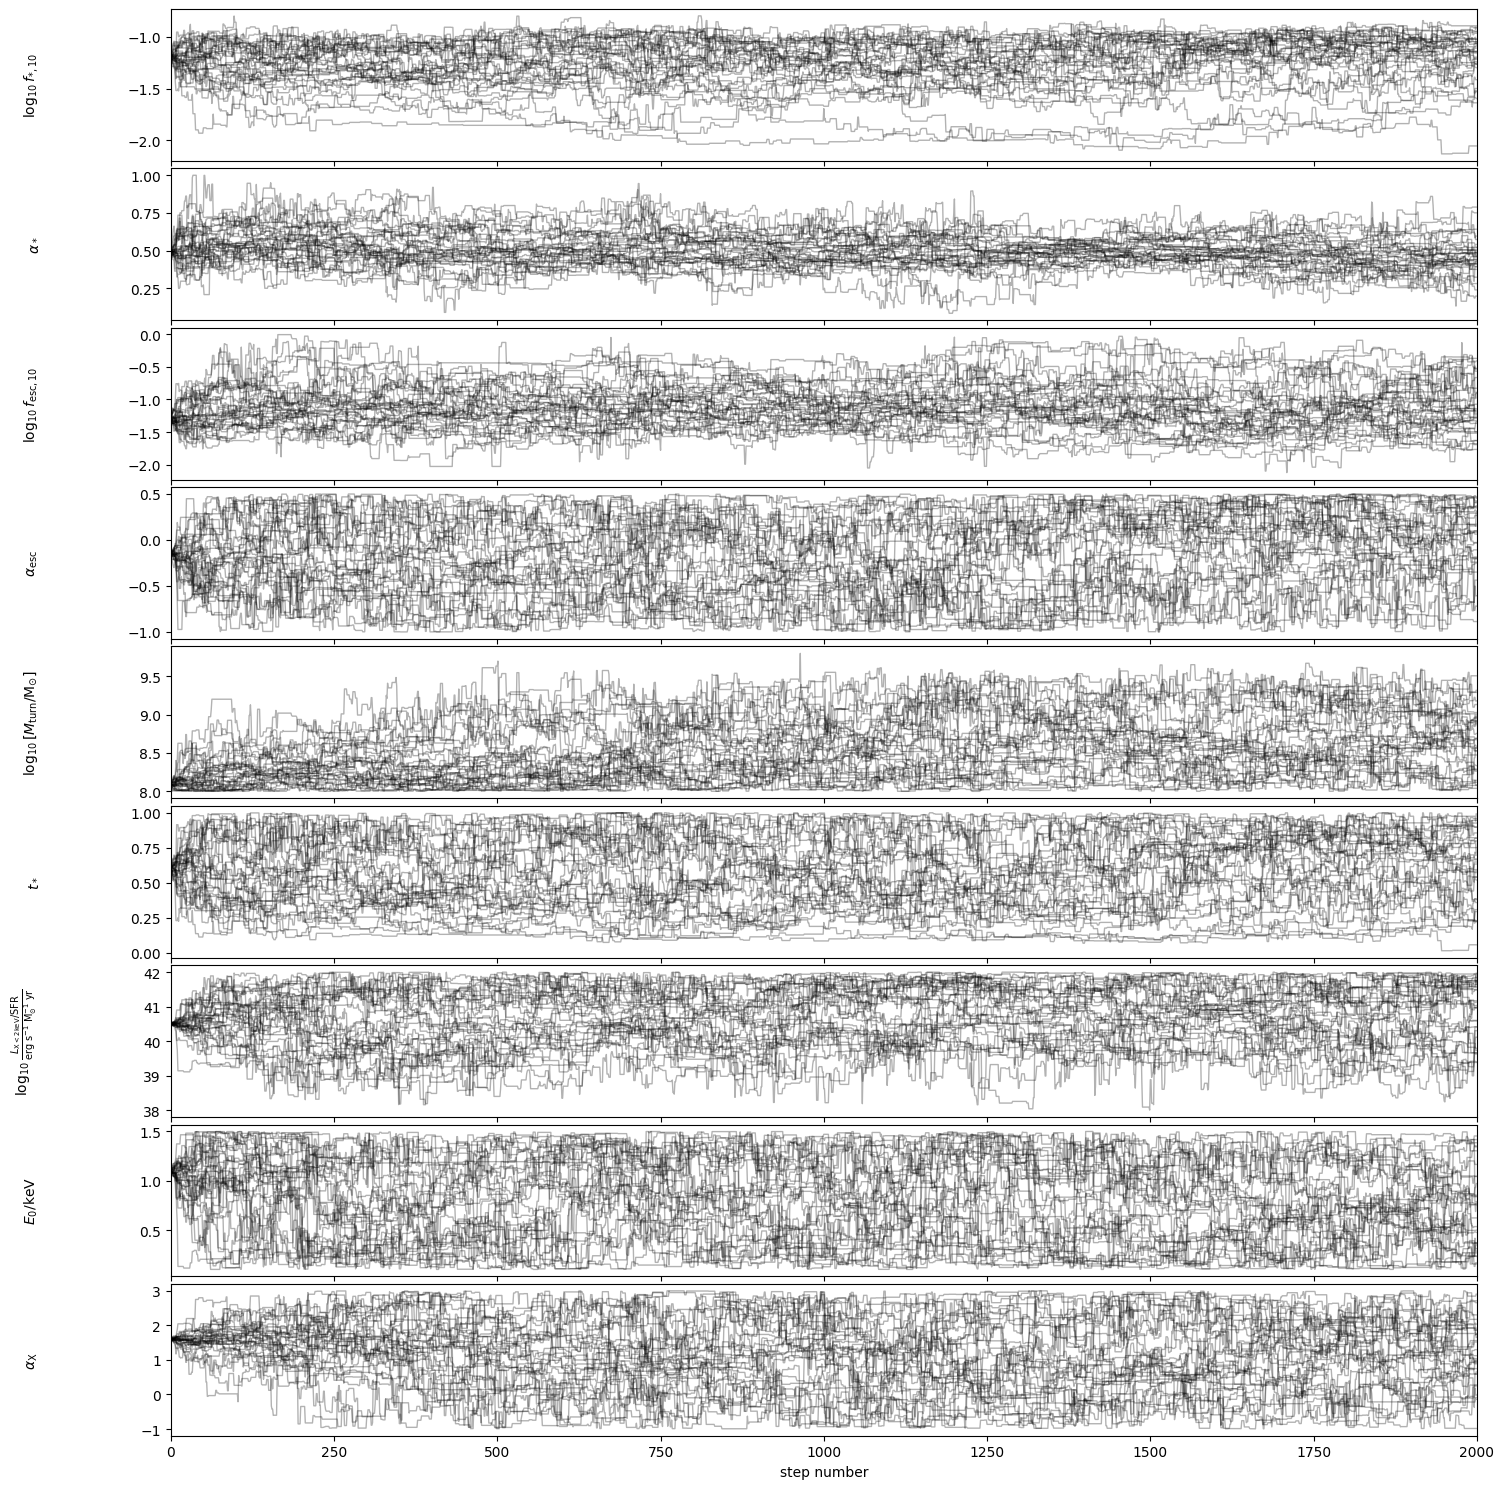

In [8]:
fig, axes = plt.subplots(len(parameters), figsize=(15, 15), sharex=True)
samples = np.swapaxes(sampler.chain, 0,1)
samples
for i in range(len(parameters)):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3, lw=1)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

# let's see the new posterior

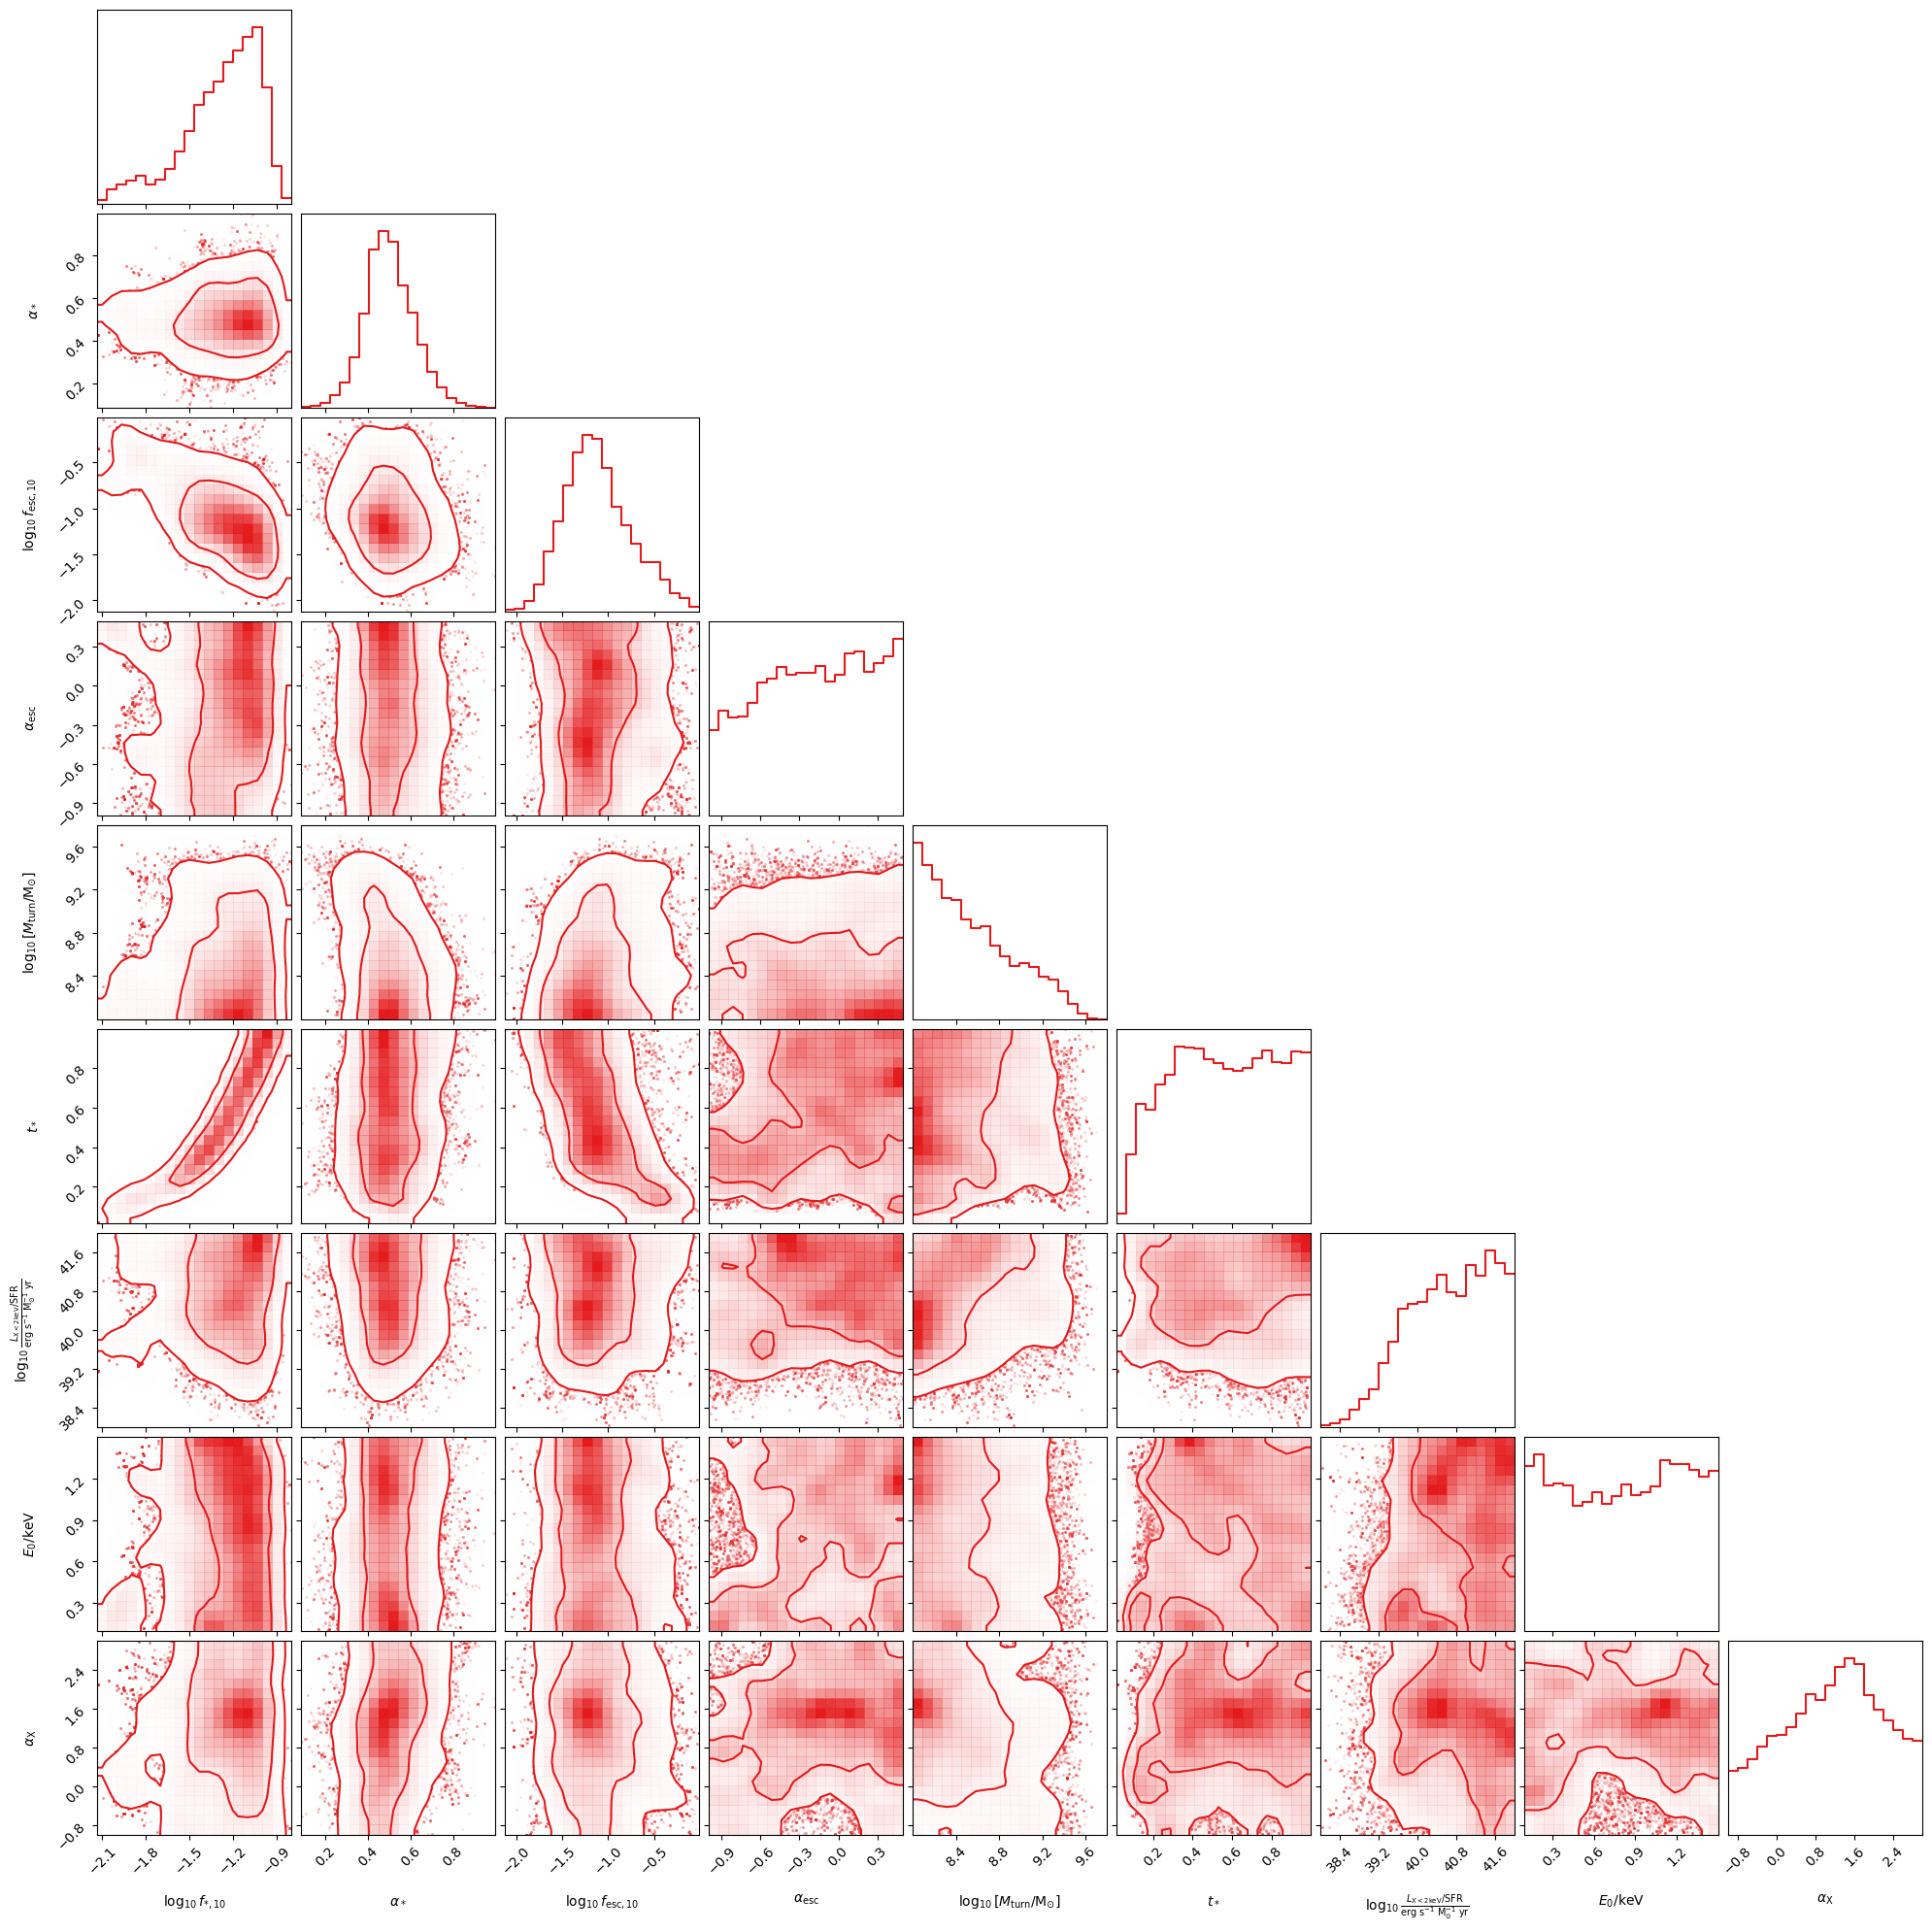

In [9]:
fig = corner.corner(samples.reshape([-1,len(parameters)]), labels=parameters,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c')

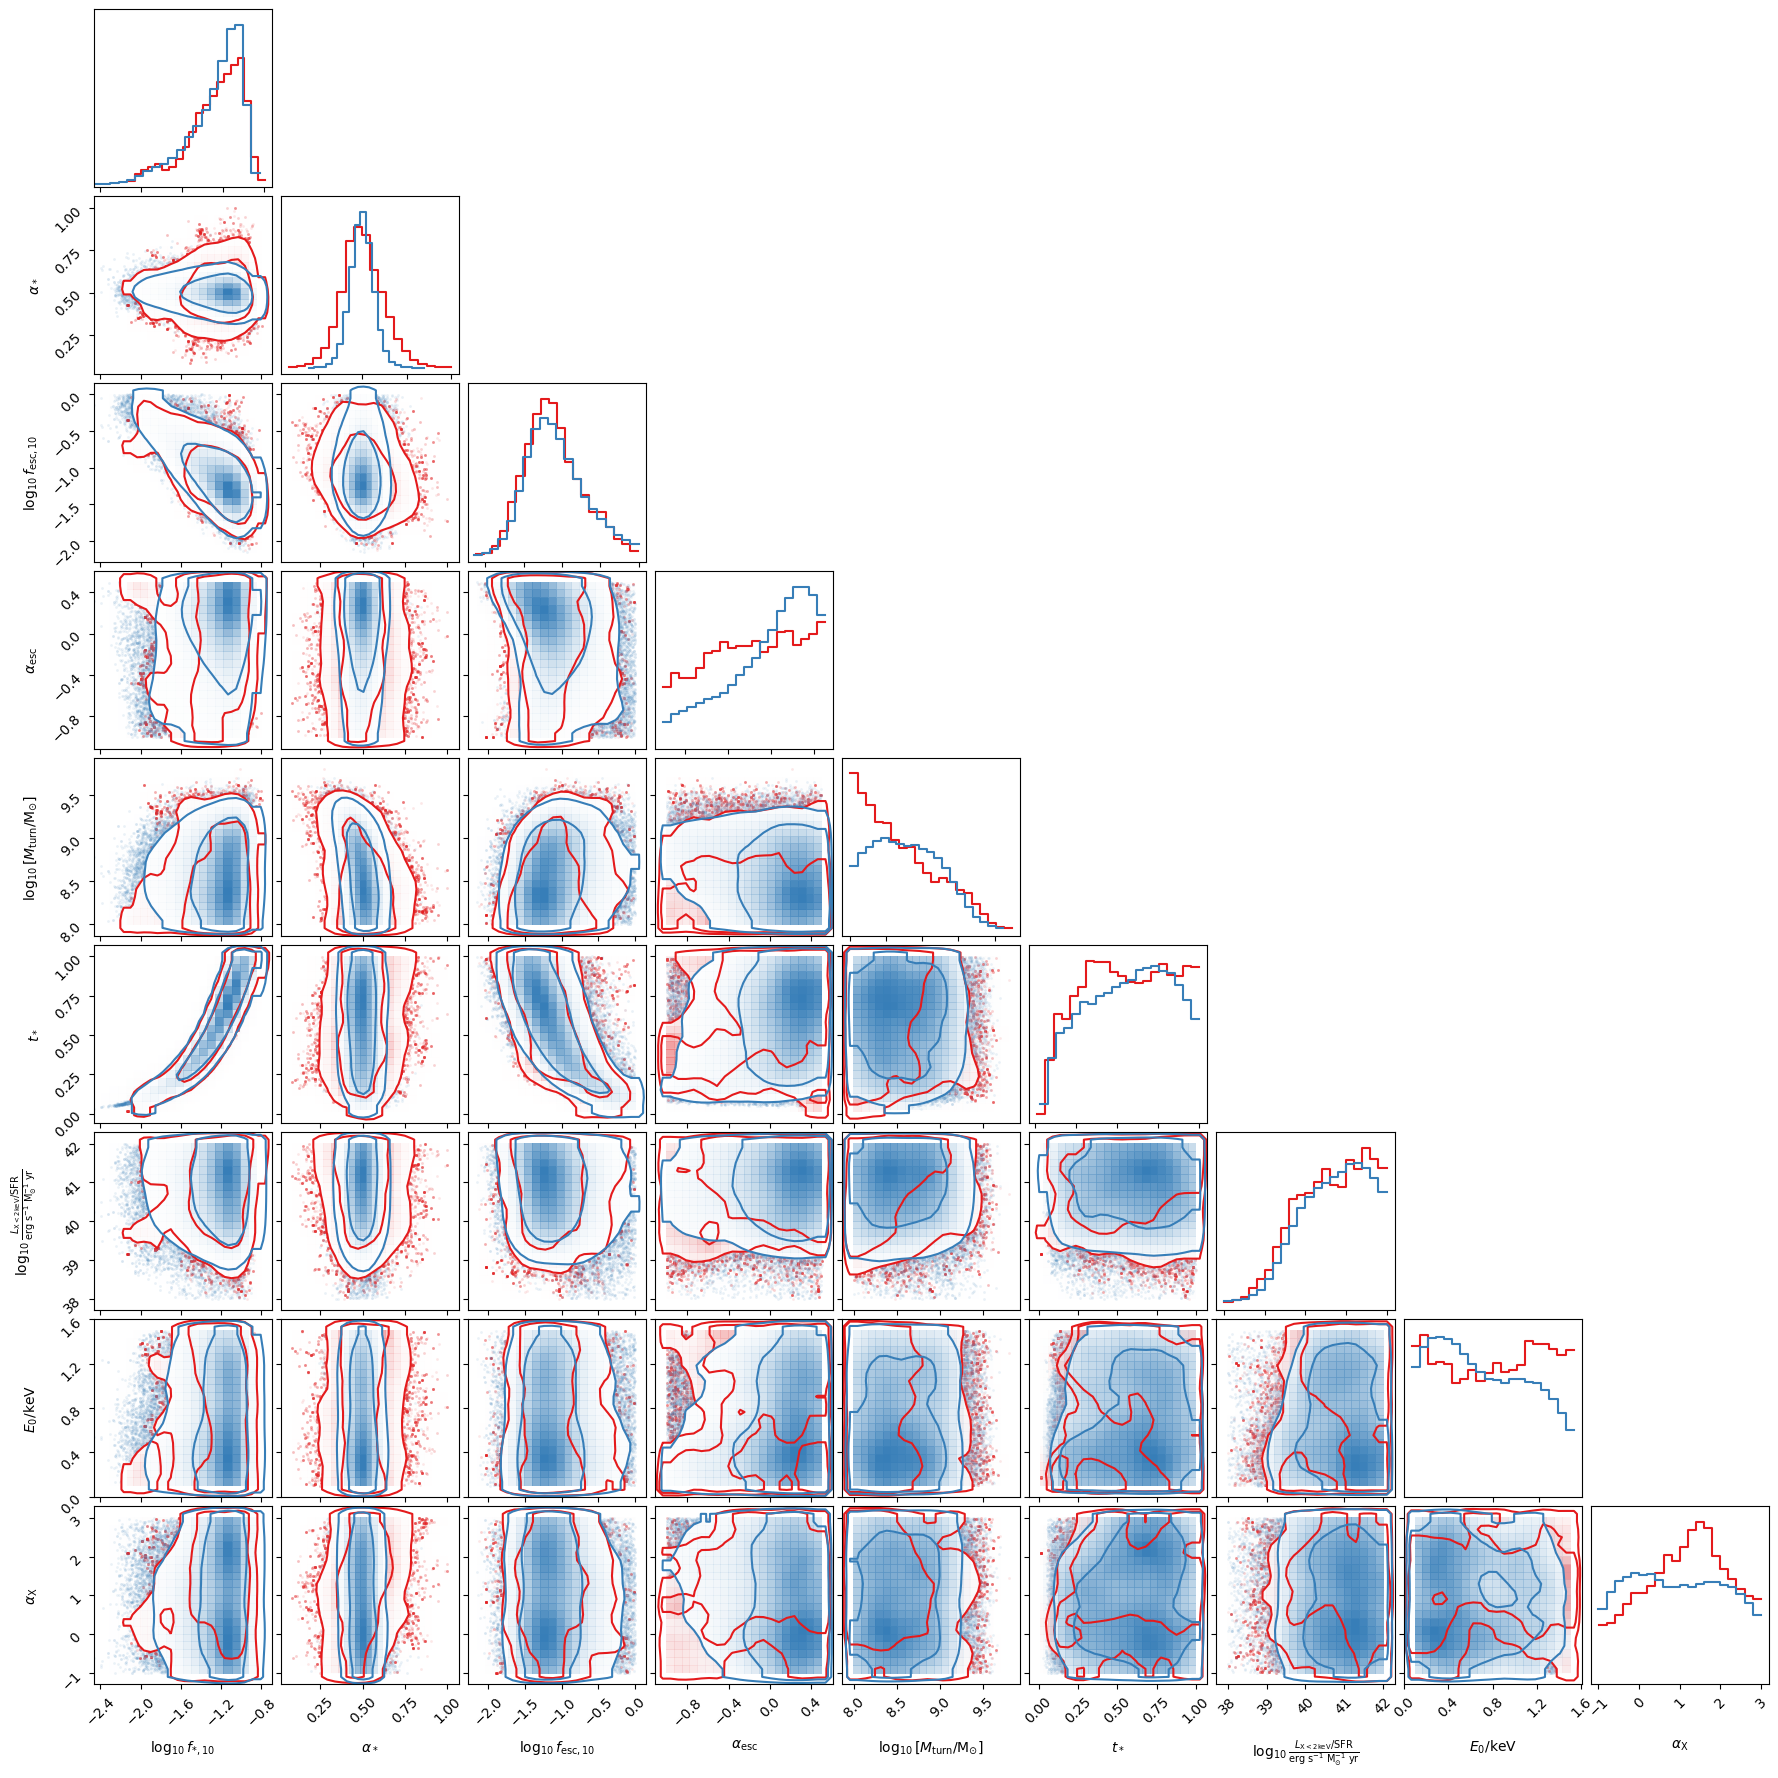

In [10]:
posterior = np.loadtxt('MultiNest/21CMMC-post_equal_weights.dat') 
plot_data = posterior[:,:-1] * (limits[:,1] - limits[:,0]) + limits[:,0]

fig, axs = plt.subplots(9,9, figsize=(18,18))
corner.corner(samples.reshape([-1,len(parameters)]), labels=parameters,fig=fig,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c');

corner.corner(plot_data, labels=parameters, fig=fig,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#377eb8');